In [15]:
# from https://python-graph-gallery.com/circular-barplot-with-groups/

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
# Ensures reproducibility of random numbers
rng = np.random.default_rng(123)

# Build a dataset
df = pd.DataFrame({
    "name": [f"First second third {i}" for i in range(1, 41)],
    "value": rng.integers(low=30, high=100, size=40),
    "group": ["A"] * 10 + ["B"] * 20 + ["C"] * 10 #+ ["D"] * 8
})

# Reorder the dataframe
df_sorted = (
    df
    .groupby(["group"])
    .apply(lambda x: x.sort_values(["value"], ascending = False))
    .reset_index(drop=True)
)

In [19]:
import sys
sys.path.insert(0,'../../')
from src.analysis.model_performances import *
from helpers import *

questions_dir = f'{DATA_PATH}/questions_m1'
ids_file_name = 'dataset_ids.test'
selected_ids = open_jsonl(f'{DATA_PATH}/{ids_file_name}.jsonl')
questions_by_id = gather_questions(questions_dir, selected_ids)
total_text = ' '.join([q['question'] for q in questions_by_id.values()])

In [43]:
import nltk
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

# Ensure that you have the necessary nltk resources downloaded:
nltk.download('punkt')
nltk.download('stopwords')


# Ensure that you have the necessary nltk resources downloaded:
nltk.download('punkt')

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

def generate_ngrams_with_counts(text, n):
    text = clean_text(text)
    words = word_tokenize(text)
    # filtered_words = [word for word in words if word not in set(stopwords.words('english'))]

    # Generate n-grams
    n_grams = ngrams(words, n)
    # Count the n-grams and return them
    counter = Counter(n_grams)
    total_sum = sum(counter.values())
    all = []
    for gram, count in counter.items():
        all.append({'n': n, 'text': ' '.join(gram), 'count': count, 'ratio': count / total_sum})
    return sorted(all, key=lambda x: x['count'], reverse=True)


TOP_N = 15
bigrams = generate_ngrams_with_counts(total_text, 2)[:TOP_N]
trigrams = generate_ngrams_with_counts(total_text, 3)[:TOP_N]
fourgrams = generate_ngrams_with_counts(total_text, 4)[:TOP_N]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paveldolin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paveldolin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paveldolin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
all = bigrams + trigrams + fourgrams
values, labels, groups = zip(*[(i['ratio']*4000, i['text'], i['n']) for i in all])
df = pd.DataFrame({
    "name": labels,
    "value": values,
    "group": groups
})
df_sorted = (
    df
    .groupby(["group"])
    .apply(lambda x: x.sort_values(["value"], ascending = False))
    .reset_index(drop=True)
)

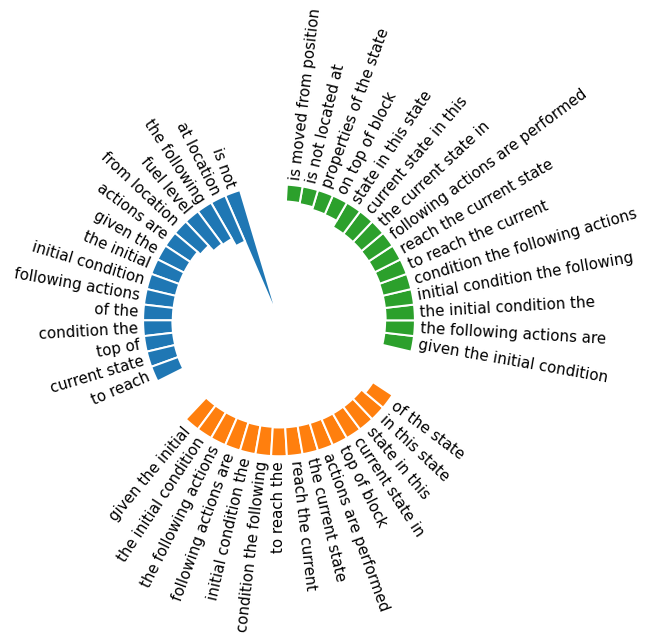

In [55]:
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 4
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=padding, #value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",
            size=15
        ) 

VALUES = df_sorted["value"].values 
LABELS = df_sorted["name"].values
GROUP = df_sorted["group"].values
OFFSET = np.pi / 2
PAD = 3
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))

ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

GROUPS_SIZE = [len(i[1]) for i in df.groupby("group")]


offset = 0
IDXS = []
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})

ax.set_theta_offset(OFFSET)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

GROUPS_SIZE = [len(i[1]) for i in df.groupby("group")]
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# Add bars to represent ...
ax.bar(
    ANGLES[IDXS], -VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)


save_main_dir = f'{STATISTICS_PATH}.{ids_file_name}'
save_dir = os.path.join(save_main_dir, 'plots', 'by_dataset')
save_name =  f'n-grams'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, f'{save_name}.pdf')
plt.savefig(save_path, transparent=True, format="pdf", bbox_inches='tight')